In [2]:
from transformers import AutoProcessor, AutoModelForSequenceClassification
import torch
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
from tqdm import tqdm

import warnings
import os

warnings.filterwarnings("ignore", category=FutureWarning)

os.environ["TOKENIZERS_PARALLELISM"] = "false"

2024-04-27 13:53:53.202281: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-27 13:53:53.202352: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-27 13:53:53.203917: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
df = pd.read_csv('/kaggle/input/test-layoutlmv3/test_dataset.csv')# test_dataset.csv')

df.head()

,filename,target,relative_path
0,2028706570.jpg,invoice,docs-sm/invoice/2028706570.jpg
1,2081145368.jpg,advertisement,docs-sm/advertisement/2081145368.jpg
2,87065276.jpg,invoice,docs-sm/invoice/87065276.jpg
3,2023855337.jpg,advertisement,docs-sm/advertisement/2023855337.jpg
4,518303535+-3536.jpg,handwritten,docs-sm/handwritten/518303535+-3536.jpg


In [5]:
df.shape

(498, 3)

In [6]:
processor = AutoProcessor.from_pretrained('microsoft/layoutlmv3-base', apply_ocr=True)
model = AutoModelForSequenceClassification.from_pretrained('davidhajdu/fine-tuned-rvl-cdip')

In [7]:
df['predicted_class'] = None

In [8]:
model.to(device)

LayoutLMv3ForSequenceClassification(
  (layoutlmv3): LayoutLMv3Model(
    (embeddings): LayoutLMv3TextEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (x_position_embeddings): Embedding(1024, 128)
      (y_position_embeddings): Embedding(1024, 128)
      (h_position_embeddings): Embedding(1024, 128)
      (w_position_embeddings): Embedding(1024, 128)
    )
    (patch_embed): LayoutLMv3PatchEmbeddings(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (encoder): LayoutLMv3Enco

In [10]:
path = "/kaggle/input/real-world-documents-collections/"
for ix, row in tqdm(df.iterrows(), total=df.shape[0]):
    img = Image.open(os.path.join(path, row.relative_path)).convert("RGB")
    encoded_inputs = processor(img, padding="max_length", truncation=True, return_tensors="pt").to(device)
    outputs = model(**encoded_inputs)

    logits = outputs.logits
    predicted_class_idx = logits.argmax(-1).item()
    predicted_class = model.config.id2label[predicted_class_idx]

    df.loc[ix, 'predicted_class'] = predicted_class

100%|██████████| 498/498 [11:46<00:00,  1.42s/it]


In [12]:
print(classification_report(df['target'], df['predicted_class']))

                        precision    recall  f1-score   support

         advertisement       0.93      0.81      0.87        32
                budget       0.71      0.84      0.77        32
                 email       0.97      0.97      0.97        32
           file_folder       0.84      0.89      0.86        36
                  form       0.85      0.74      0.79        39
           handwritten       0.81      0.87      0.84        30
               invoice       0.85      0.79      0.81        28
                letter       0.86      0.89      0.87        27
                  memo       0.86      0.86      0.86        21
          news_article       0.86      0.82      0.84        22
          presentation       0.68      0.84      0.75        25
         questionnaire       0.89      0.95      0.92        41
                resume       0.97      0.90      0.93        31
scientific_publication       0.97      0.89      0.93        38
     scientific_report       0.81      

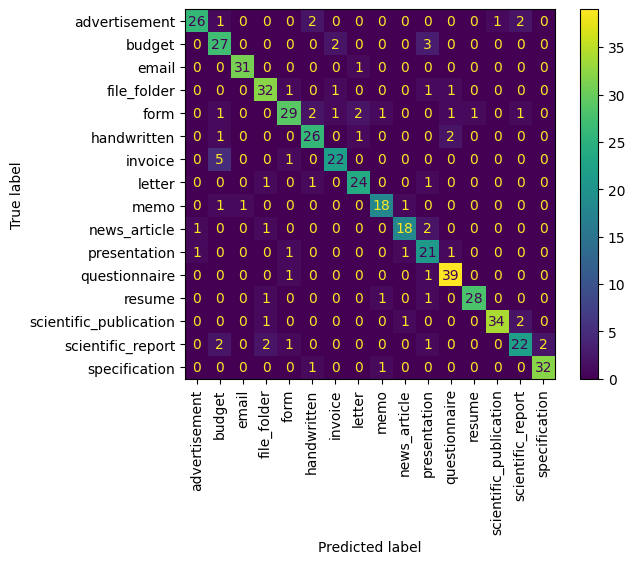

In [18]:
import matplotlib.pyplot as plt

disp = ConfusionMatrixDisplay.from_predictions(df['target'], df['predicted_class'], xticks_rotation='vertical')